# Here, we explore results and explain some methods regarding:

- Similarity matrices for the set of chemical elements, yearly.
- Optimization with genetic algorithms.

## This involves:

- Visualization of similarity matrices.
- Computation of baselines for optimization of permutations of list of elements.
- Visualization of reshuffled matrices.
- Formulation/explanation of a method for comparison of permutations.
- Testing such a method
- Historical analysis: Comparison of permutations (PSs) between all pairs of years.

In [1]:
import sys
sys.path.append('../similarity')
sys.path.append('../Genetic1D')

from simMat import *

dataPath = '../Data/'

# Load similarity matrices
simMat_yr = np.load(dataPath + 'simMat.npy',allow_pickle=True)
min_yr = 1800

cmap=cm.get_cmap("jet")

# Load element list
elemList = getElemList('../Data/')

## Visualization of the obtained similarity matrices

- Modify `year` to see evolution of similarities

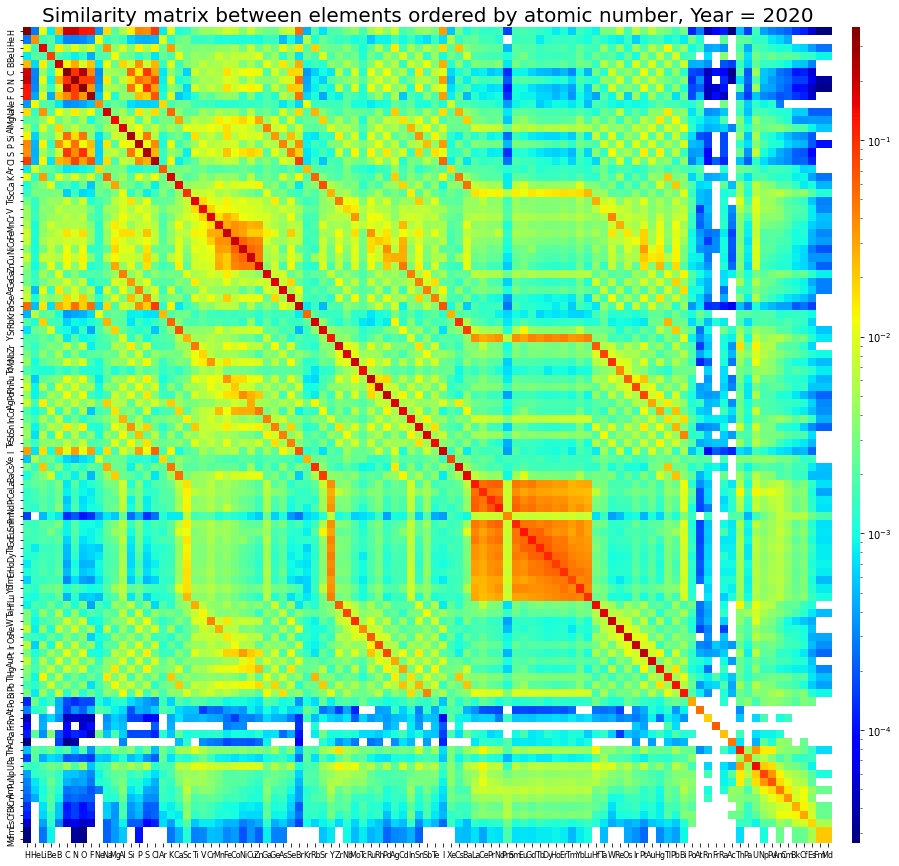

In [2]:
year = 2020

plot_simMat_yr(simMat_yr,year,min_yr=min_yr,raw=0,scale=15,
               cmap=cmap,EL=elemList);#,save='sim{}.png'.format(year));

## Optimal Permutations: 1D-Periodic Systems.

- Calculate errors of previously computed permutations (i.e. Atomic Number ordering, and others from refs. [Pettifor](https://www.sciencedirect.com/science/article/pii/0038109884907658) and [Glawe et.al.](https://iopscience.iop.org/article/10.1088/1367-2630/18/9/093011))

In [4]:
from genetic1D import *

# Calculate P for calculating cost function
year=2016
S = simMat_yr[year - min_yr].copy()
P = symmetrize(S)

print("Relative to similarity matrices of {}, different orderings perform as follows:\n".format(year))

# Set a reference ordering: atomic number
orderAO = np.arange(P.shape[0])

print(f"Cost using AN order = {cost(P, orderAO):.5f}")

# 2. Check how Pettifor's scale does on these data.
pettif = ['He','Ne','Ar','Kr','Xe','Rn','Fr','Cs','Rb','K','Na','Li','Ra','Ba','Sr','Ca','Yb','Eu','Y',
          'Sc','Lu','Tm','Er','Ho','Dy','Tb','Gd','Sm','Pm','Nd','Pr','Ce','La','Lr','No','Md','Fm','Es',
          'Cf','Bk','Cm','Am','Pu','Np','U','Pa','Th','Ac','Zr','Hf','Ti','Nb','Ta','V','Mo','W','Cr',
          'Tc','Re','Mn','Fe','Os','Ru','Co','Ir','Rh','Ni','Pt','Pd','Au','Ag','Cu','Mg','Hg','Cd','Zn',
          'Be','Tl','In','Al','Ga','Pb','Sn','Ge','Si','B','Bi','Sb','As','P','Po','Te','Se','S','C','At',
          'I','Br','Cl','N','O','F','H']

# List the position of each element in Pettifor scale
order_pett = np.array([pettif.index(e) for e in elemList])
# e.g. H: 102, He: 0, Li: 11, etc
print(f"Cost Pettifor = {cost(P, order_pett):.5f}")

# See how their GA solution works

GA_ref = ['He','Ne','Ar','At','Rn','Fr','Es','Fm','Md','No','Lr','Kr','Xe','Pm','Cs','Rb','K','Na',
          'Li','Ra','Ba','Sr','Ca','Eu','Yb','Lu','Tm','Y','Er','Ho','Dy','Tb','Gd','Sm','Nd','Pr',
          'Ce','La','Ac','Am','Cm','Bk','Cf','Pu','Np','U','Th','Pa','Sc','Zr','Hf','Ti','Nb','Ta',
          'V','Cr','Mo','W','Re','Tc','Os','Ru','Ir','Rh','Pt','Pd','Au','Ag','Cu','Ni','Co','Fe',
          'Mn','Mg','Zn','Cd','Hg','Be','Al','Ga','In','Tl','Pb','Sn','Ge','Si','B','C','N','P','As',
          'Sb','Bi','Po','Te','Se','S','O','I','Br','Cl','F','H']

# List the position of each element in Pettifor scale
order_GA = np.array([GA_ref.index(e) for e in elemList])
# e.g. H: 102, He: 0, Li: 11, etc
print(f"Cost GA Glawe = {cost(P, order_GA):.5f}\n")


# Performance of random configurations
print("Cost achieved by random permutations:\n")
rand_ord_cost = [cost(P, np.random.permutation(orderAO)) for i in range(5000)]
print(pd.Series(rand_ord_cost).describe())

Relative to similarity matrices of 2016, different orderings perform as follows:

Cost using AN order = -8.65563
Cost Pettifor = -12.77233
Cost GA Glawe = -12.85895

Cost achieved by random permutations:

count    5000.000000
mean       -4.364856
std         0.231145
min        -5.530532
25%        -4.503367
50%        -4.341609
75%        -4.200020
max        -3.799068
dtype: float64


Random orderings have F values typically between $-4$ and $-5$, while using AN ordering improves this value down to $-8.66$. Pettifor does much better, and the GA solution does perform better than the original Pettifor scale, although is not as dramatic a result as reported in ref.

--- 

## Genetic algorithms for optimization of permutations of elements, analog to Pettifor scale).

Ultimately, what we need to do is find an optimal permutation of the numbers in the range from 0 to $N$ ($N=103$ in 2015). 

The algorithm (as implemented in `genetic1D.py`) works as follows:

- An `Individual` class is created. And instance of this is a particular ordering with derived properties such as cost, and functions useful for optimization, such as crossover and mutate.

- A `Population` class is created. This generates a collection of `Individual` instances, and allows to optimize from this gene pool.

### Code for an optimization looks as follows:
<br>

```python
T , popSize, NGens, mutRate = 0.4,1000, 500, 0.2
breed = Population(popSize, 103, P=P).evolve(NGens,T=T,mutRate=mutRate)
```

Parameters T, popSize, NGens, mutRate must be tuned.

- T is a temperature parameter of a Boltzmann's distribution. It controls how much highlighted are best-performing individuals each generation.

---

## Let's see some results of our optimizations

In [5]:
fh = open('../Results/optim_permut_yearly.gen', 'rb') 
Indivs_yr = pickle.load(fh)

Best cost obtained for year 2016 is -14.123


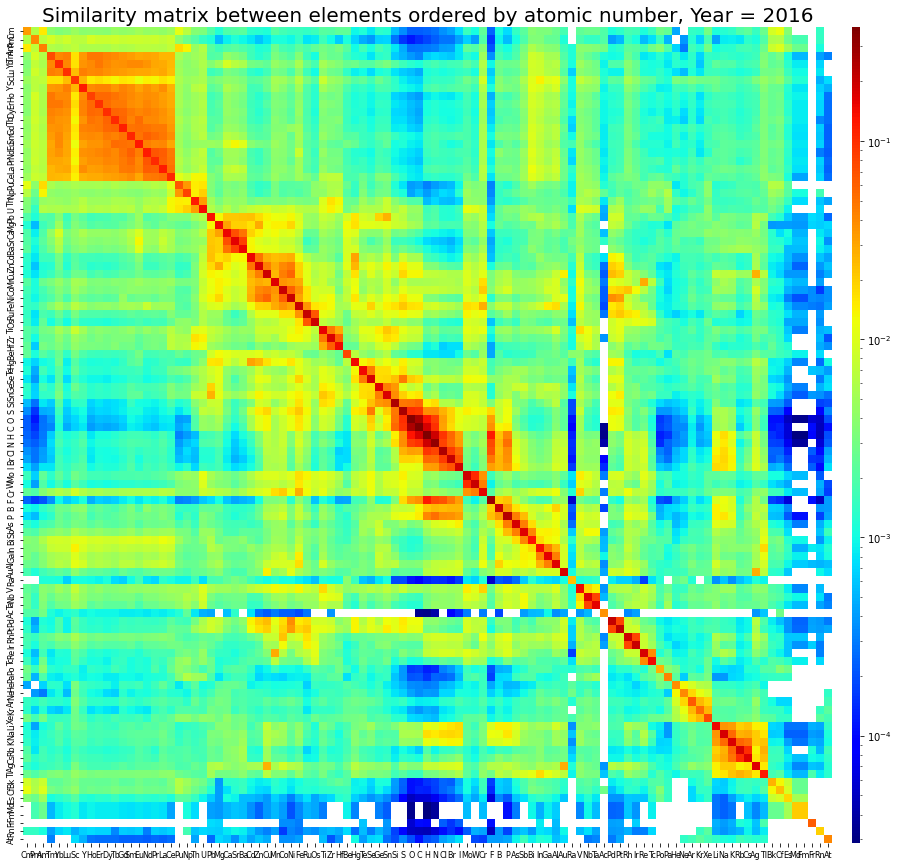

In [6]:
def bestInd(year):
    S = simMat_yr[year - min_yr].copy()
    P = symmetrize(S)

    best_in, best_cost = None, 0
    for i in Indivs_yr[year]:
        c = cost(P, i)
        if c<best_cost:
            best_cost=c
            best_in=i
    return best_in, best_cost


year=2016
best_in, best_cost = bestInd(year)

plot_simMat_yr(simMat_yr,year,min_yr=min_yr,raw=False,scale=15,
               ordering=best_in,cmap=cmap,EL=elemList)#,save="simmatopt{}.png".format(year))

print("Best cost obtained for year {} is {:.3f}".format(year,best_cost))

### Best cost is -14.123, improving from -12.859 being the best baseline.

---

At this point, there are 50 such optimized permutations for each year.

# How to quantitavely compare the orderings? 


## As opposed to the reference, where the authors visually inspected the orderings, here we'll use more formal quantities that allow to rate similarities between scales, and don't depend on fixed extremes (ref. [Glawe et.al.](https://iopscience.iop.org/article/10.1088/1367-2630/18/9/093011) used Kr and H to be fixed as fixed extremes of the permutations).

# <span style="color: red"> Note: The cost function may not be used for this, as it depends on a similarity matrix. We want to compare permutations corresponding to different years, thus dependance on some particular similarity matrix make results ambiguous.</span>

Given the interpretation of these permutations, the most important feature, and thus what we want to compare, is $\textbf{closeness of similar elements}$.

In essence, given two permutations $P_1$ and $P_2$ of the list of elements, we wish to quantify the ammount of times the same pair of elements is found within some distance ---or radius--- $r$, in both permutations.

For instance, consider the permutations:

1. <span style="background-color: #2ee7c9">A B C D E F G H I J</span>


2. <span style="background-color: #2ee730">J F E I C G B H D A</span>

To illustrate what is meant by `distance`, consider $P_1$. Here, `E` is a distance 1 away from `F`, and 2 away from `C` and `G`.


Suppose we take $r=2$. With this, we find that the pairs <span style="background-color: #FFFF00">B-D, C-E, G-H</span> and <span style="background-color: #FFFF00">G-I</span> are found within a radius $r=2$, in both permutations.

### In this example, similarity = 4, i.e. the number of pairs of elements that are found to satisfy the conditions.

This number should then be properly normalized.

## First, let's determine what an appropriate value for <span style="color:blue">r</span> is.

We'll do this by studying the relation between this quantity, and difference in cost.

In [263]:
def comparePerms(p1,p2,r=5):
    """
    Compare permutations `p1` and `p2` using method explained above.
    """
    p1 = np.abs(p1 - p1.reshape(-1,1))
    p2 = np.abs(p2 - p2.reshape(-1,1))

    p1 = np.triu(p1,k=1)
    p2 = np.triu(p2,k=1)

    p1[p1==0]=200
    p2[p2==0]=200
    
    sim = np.sum((p1<=r)*(p2<=r))
    
    # Normalized by comparison of p1 with itself
    return sim/np.sum((p1<=r)*(p1<=r))

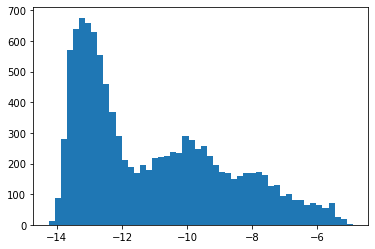

In [264]:
# Get a bag of sample individuals

bag = []

for y in Indivs_yr.values():
    bag = bag + y
    
# Get costs for every individual using P of 2021 as reference
year = 2021
S = simMat_yr[year - min_yr].copy()
P = symmetrize(S)
    
bag_costs = []
for I in bag:
    bag_costs.append(cost(P,I))
    
# Distribution of costs
plt.hist(bag_costs,bins=50);

# Get best individual
best_i = np.argmin(bag_costs)
best_ind = bag[best_i]
best_cost = bag_costs[best_i]

# Calc diff in costs
dif_costs = list(np.array(bag_costs) - best_cost)

# Remove best individual, not to compare twice
dif_costs.pop(best_i)
bag.pop(best_i);

### We have a good sample of costs, but distribution is far from normal.

Let's take a subsample of this, that looks more normal.

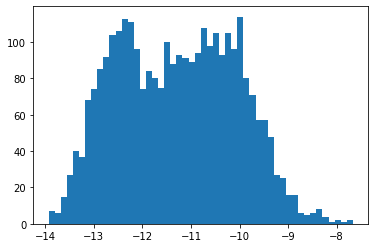

In [265]:
# Assign a gaussian probability to each value in bag_costs, and sample using that
def gaussian(X, mn, sd):
    p = np.exp(-0.5 * ((X-mn)/sd)**2)
    return p

mn, sd = np.mean(bag_costs), 1
p = gaussian(bag_costs, mn, sd)
p = p/p.sum()

new_samp = np.random.choice(range(len(bag_costs)),
                            p=p, size=3000, replace=False)


plt.hist(np.array(bag_costs)[new_samp],bins=50);

Text(0, 0.5, 'Cost difference')

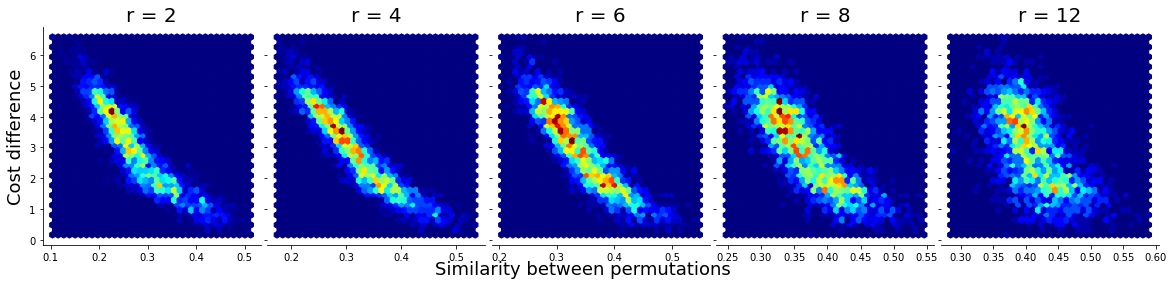

In [271]:
dif_costs_samp = np.array(dif_costs)[new_samp]
bag_samp = np.array(bag)[new_samp]

# Compare difference in cost against similarity measure
rs = [2,4,6,8,12]

comp_rs = [[comparePerms(p1,best_ind,r=r) for p1 in bag_samp] for r in rs]


fig, ax = plt.subplots(1,5,figsize=(20,4),sharey=True,gridspec_kw={'wspace':0.03})
for i, r in enumerate(rs):
    ax[i].hexbin(x=comp_rs[i], y=dif_costs_samp,gridsize=35,cmap=cmap)
    ax[i].set_title(f'r = {r}',fontsize=20)

for i in range(5):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
ax[0].spines['left'].set_visible(True)

fig.supxlabel('Similarity between permutations',fontsize=18)
ax[0].set_ylabel('Cost difference',fontsize=18)

## A value around 4 seems ideal, as higher values seem to disperse too much, while lower values lead to way too low values of similarity.

---

In [298]:
def historyMatrix(p, r):
    """
    This is a highly vectorized version of `comparePerms`.
    In each iteration, compares a single permutation, simultaneously with one for each year (222 total).
    
    r is radius to consider elements to be close in a sequence.
    p is number of permutations to use. Use only the best `p` found each year.
    """
    
    # Each year, sort optimized permutations by cost
    Indivs_yr_sort = {}
    for yr in Indivs_yr.keys():
        Indivs_yr_sort[yr] = []

        S = simMat_yr[yr - min_yr].copy()
        P = symmetrize(S)

        a = np.array([cost(P,ind) for ind in Indivs_yr[yr]])

        # Sort the list of Individuals for each year, based on cost
        order = np.argsort(a)
        Indivs_yr_sort[yr] = np.array(Indivs_yr[yr])[order]


    # Calc if diag entry of element `i` is > 0 in simMat for every year
    exist_elems = np.einsum('ijj->ij',simMat_yr)>0

    # Convert to array of dim (222, 50, 103, 1)
    a = np.array([Indivs_yr_sort[y] for y in range(1800,2022)])[...,np.newaxis]

    # Get matrix of distances between each pair of elements, in each permutation
    a = np.abs(a - a.reshape(222, 50, 1, 103))

    # Get only upper diag of matrix, so combs. of elements are not repeated
    a = np.triu(a,k=1)

    # And convert these elements two high values, so don't count in sum
    a[a==0] = 200

    # Initialize matrix of historical comparisons
    matrix = np.zeros((222,222))

    # Iterate over year, and two indexes of permutation.
    for i,y in enumerate(range(1800,2022)):
        for j in range(p):
            for k in range(p):

                # Mask elements that don't exist this year
                mask = exist_elems[i]
                mask = ~(mask * mask.reshape(-1,1)) * 1
                mask[mask==1] = 200 # mask[i,j] > 200 if either ith or jth element don't exist, else 0

                # Sum mask. If elements exist, values are not modified. Thus if val < r, condition is satisfied.
                l1 = (a[i,j] + mask) <= r
                l2 = (a[:,k] + mask) <= r

                sim = np.sum(l1*l2, axis=(1,2))

                # Normalize using one of this year's permutation
                nor = np.sum(l1*l1) # Compare perm to itself

                matrix[i] += sim/nor  # Sum now, divide by number of combinations later

    # This division gets the average.
    return matrix/p**2

def plotHistory(matrix,sz=15,pad=4,save=False):
    
    fig,ax = plt.subplots(2,1,figsize=(sz,sz),
                           gridspec_kw={"height_ratios":[100,1],"hspace":0.15}) 
    
    sns.heatmap(matrix,norm=LogNorm(),ax=ax[0],cmap=cmap,cbar_ax=ax[1],
                cbar_kws={"orientation":"horizontal","ticks":[5e-1]})

    matrix[0,0] = 0
    
    labels = [i for j,i in enumerate(Indivs_yr.keys()) if j%10==0]
    locs = (np.array(labels) - 1800)  + 0.5
    ax[0].set_xticks(locs)
    ax[0].set_yticks(locs)
    ax[0].set_xticklabels(labels,rotation=90)
    ax[0].set_yticklabels(labels,rotation=0)
    ax[0].invert_yaxis()
    ax[0].yaxis.tick_right()
    

    
    # Embed another plot
    x,y, h, w = .1, .55, .2, .45
    ax2 = fig.add_axes([x,y, w, h])
    #ax2.plot(range(1801,2020),np.diff(np.log(matrix[:-1,-1]))+0.3, 
    #         color="red",lw=1, label="inside plot")
    ax2.plot(range(1801,2021),matrix[:-1,-1], color="blue",lw=1, label="inside plot")
    
    ax2.axvline(1825,color='k',linestyle='--',linewidth=0.6)
    ax2.set_title("Profile for PS 2021")
    
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.set_facecolor(color="None")
    ax2.set_alpha(alpha=0.1)
    
    if save:
        plt.savefig(save,dpi=300,bbox_inches='tight')

In [33]:
%%time
# Calculate history matrix using r=4 and 20 best permutations. of each year.
matrix_r4 = historyMatrix(20,4)

CPU times: user 21min 2s, sys: 652 ms, total: 21min 2s
Wall time: 21min 3s


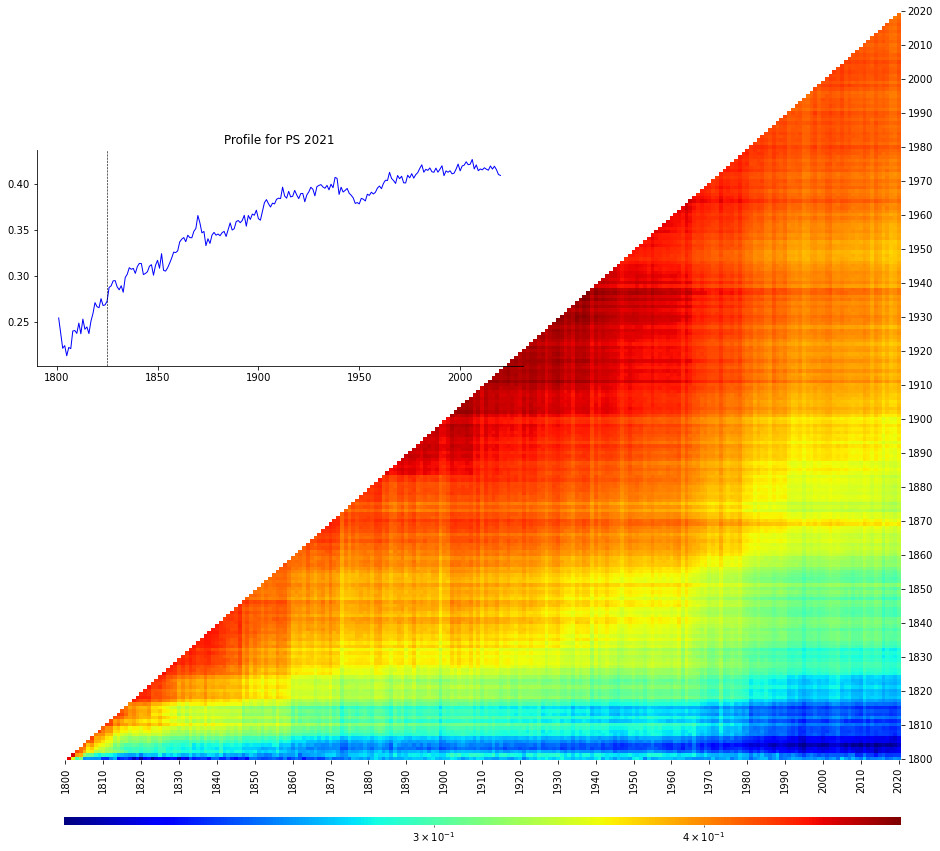

In [299]:
# Don't consider 1800.
plotHistory(np.triu(matrix_r4)[1:][:,1:])

## Interpretation:

Compare PSs of years in `y` axis, with PSs of year in `x` axis.

e.g. `x=2020` and `y=1908`. Value is: What percentage of relations found in 2020, had already been found in 1908?